In [2]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from tensorflow.keras import layers
import time
import pandas as pd

from IPython import display
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# converting images into numpy arrays
path = "/content/drive/MyDrive/cats2"
lst = os.listdir(path)
train_images = []
for filename in lst:
  file_path = os.path.join(path, filename)
  image = Image.open(file_path)
  image = image.resize((64, 64))
  image_array = np.array(image)
  train_images.append(image_array)


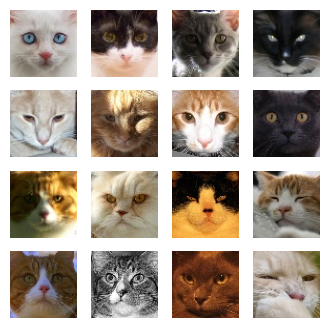

In [13]:
for i in range(len(train_images)):
  if train_images[i].shape != (64, 64, 3):
    image = np.resize(train_images[i], (64, 64, 3))
    train_images[i] = image


train_images = np.stack(train_images, axis=0)

# display some images

fig = plt.figure(figsize=(4, 4))
for i in range(16):
      plt.subplot(4, 4, i+1)
      plt.imshow(train_images[i])
      plt.axis('off')

plt.show()

{0: 3598, 1: 4174, 2: 7342, 3: 633}


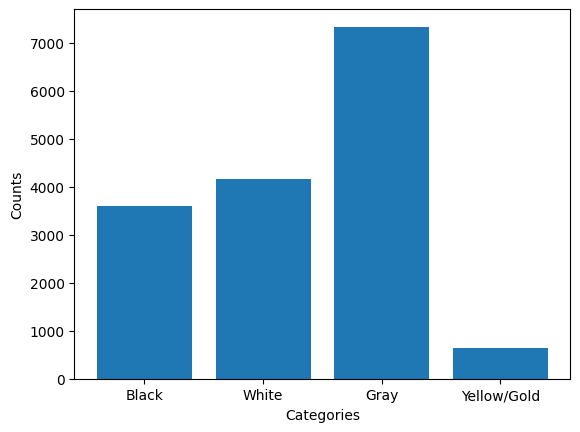

In [14]:
# getting cat sorted labels
df = pd.read_csv("/content/drive/MyDrive/SortedLabels2.csv")
values = df['value'].tolist()
train_labels = np.array(values)

# print the number of unique ones
# TODO: (perhaps would be cool to graph these in a bar graph)
color_dict = {0: "Black", 1: "White", 2: "Gray", 3: "Yellow/Gold"}
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))

categories = [color_dict[i] for i in unique]
plt.bar(categories, counts)

plt.xlabel('Categories')
plt.ylabel('Counts')

plt.show()

In [15]:
# printing types and shape
print(train_images.shape)
print(type(train_images))

print(type(train_labels))
print(train_labels.shape)

# before and after normalization
print(train_images)
train_images = train_images.reshape(train_images.shape[0], 64, 64, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
print(train_images)

BUFFER_SIZE = 15747
BATCH_SIZE = 64

# batch and shuffle data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



(15977, 64, 64, 3)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(15747,)
[[[[181 147 137]
   [190 156 146]
   [195 162 155]
   ...
   [209 178 173]
   [214 181 174]
   [197 162 156]]

  [[194 157 149]
   [191 157 148]
   [178 145 138]
   ...
   [196 165 160]
   [209 176 169]
   [195 162 155]]

  [[156 117 112]
   [181 144 138]
   [205 170 166]
   ...
   [212 182 174]
   [201 172 164]
   [220 191 183]]

  ...

  [[183 180 171]
   [182 179 170]
   [177 173 164]
   ...
   [215 214 210]
   [214 213 209]
   [219 218 214]]

  [[184 181 174]
   [181 178 171]
   [178 174 165]
   ...
   [216 215 211]
   [215 211 208]
   [221 217 214]]

  [[186 183 176]
   [181 178 171]
   [180 176 167]
   ...
   [213 212 208]
   [215 211 208]
   [225 221 218]]]


 [[[ 48  27  22]
   [ 57  36  33]
   [ 53  33  32]
   ...
   [ 46  27  23]
   [ 66  44  46]
   [199 177 179]]

  [[ 55  34  29]
   [ 48  29  25]
   [ 34  14  15]
   ...
   [ 48  28  27]
   [ 56  34  36]
   [226 204 206]]

  [[ 35  16  12]
   [ 36  1

In [16]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size
    print(model.output_shape)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(4, 4), padding='same', use_bias=False, activation='tanh'))
    print(model.output_shape)
    assert model.output_shape == (None, 64, 64, 3)


    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(None, 8, 8, 256)
(None, 16, 16, 64)
(None, 64, 64, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16384)               │       1,638,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16384)               │          65,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 3)           │           3,072 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,731,776 (10.42 MB)

 Trainable params: 2,698,624 (10.29 MB)

 Non-trainable params: 33,152 (129.50 KB)

None
tf.Tensor(
[[[127.48705  127.14712  128.54433 ]
  [127.63572  127.39779  127.13715 ]
  [127.61892  127.010216 127.67133 ]
  ...
  [127.380684 126.90075  127.054985]
  [127.06291  126.95085  127.51267 ]
  [127.83332  127.41009  127.91215 ]]

 [[127.49907  127.14174  127.55085 ]
  [127.25308  128.07802  127.1773  ]
  [127.4701   127.43358  127.418686]
  ...
  [127.243195 127.798676 127.24782 ]
  [127.37384  127.242966 127.28478 ]
  [127.182884 128.04124  127.08975 ]]

 [[127.67732  127.47446  127.777504]
  [127.260475 126.878204 127.322296]
  [127.23358  127.53967  126.75263 ]
  ...
  [127.727425 127.61485  128.0306  ]
  [127.51782  127.87671  127.96624 ]
  [127.27304  126.92467  127.61547 ]]

 ...

 [[127.49387  127.170425 127.63627 ]
  [127.70007  127.8822   126.86765 ]
  [127.72057  127.65954  127.54128 ]
  ...
  [128.21806  128.07005  127.64217 ]
  [127.97363  127.36119  126.450676]
  [127.0616   127.66505  126.96644 ]]

 [[127.561874 127.42199  127.49945 ]
  [127.4806   127.989

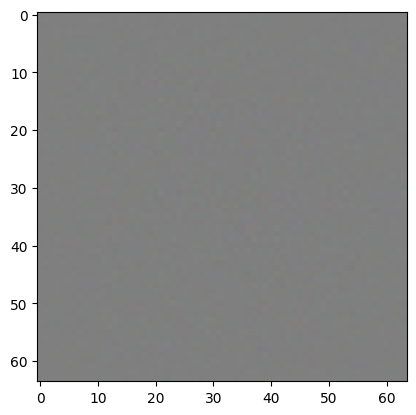

In [17]:
generator = make_generator_model()
print(generator.summary())

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

print(generated_image[0] * 127.5 + 127.5)
plt.imshow((generated_image[0] * 127.5 + 127.5).numpy().astype(np.uint8))

In [18]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [28]:
discriminator = make_discriminator_model()
print(discriminator.summary())
decision = discriminator(generated_image)
print(decision)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          16,385 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,045,633 (3.99 MB)

 Trainable params: 1,045,633 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

None
tf.Tensor([[-0.0009133]], shape=(1, 1), dtype=float32)


In [19]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
EPOCHS = 20
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [24]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
#@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [25]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i] * 127.5 + 127.5).numpy().astype(np.uint8))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [26]:
def train(dataset, epochs):
  gen_losses = []
  disc_losses = []
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      g, d = train_step(image_batch)
      gen_losses.append(g)
      disc_losses.append(d)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # # Save the model every 15 epochs
    # if (epoch + 1) % 15 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  return gen_losses, disc_losses

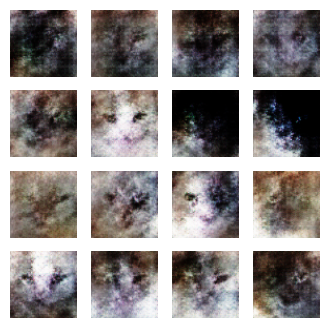

In [29]:
generator_losses, discriminator_losses = train(train_dataset, EPOCHS)

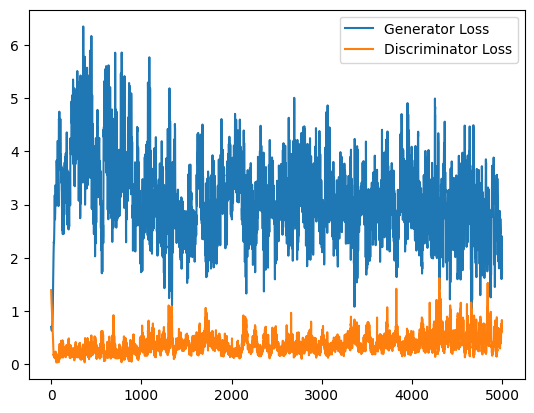

In [31]:
# generator.save()
# discriminator.save()

y = range(5000)
plt.plot(y, generator_losses, label = "Generator Loss")
plt.plot(y, discriminator_losses, label = "Discriminator Loss")
plt.legend()
plt.show()